# Example: Vertical instability (growth rate) calculations

---

This notebook will demonstrate various different ways to calculate the **growth rates** (or **timescales**) associated with **vertically unstable modes** of an equilibrium. We will explore ways to plot associated quantities and carry out eigenmode reduction. 


**Things missing** 
- More interpretation of what the growth rates/timescales mean. 




---

### The deformable growth rate model

Assume we have solved the Grad-Shafranov equation and have obtained an equilibrium. From this we can extract the plasma current density discretised over the spatial domain (these are only non-zero inside the LCFS so we mask points outside the limiter to save memory):

\begin{equation*}
    \bold{I}_y := \bold{I}_y^{GS} (\bold{I}_m, I_p, \bold{\theta}).
    \tag{1}
\end{equation*}

This is a function of the: 
- currents in the metal conductors $\bold{I}_m$ (i.e. the active coils and passive structures).
- plasma current $I_p$.
- free parameters $\bold{\theta}$ used to define the plasma current density profiles (i.e. $J_p(\psi,R,Z)$). 

In order to estimate the instability timescales/growth rates of this plasma, we will need to define (and then linearise) the coupled **circuit** and **plasma** current equations. 

**Circuit equations**: 

These equations govern the flow of current in the active coils and passive structures:

\begin{equation}
    M_{m,m} \bold{\dot{I}}_m + M_{m,y} \bold{\dot{I}}_y + R_{m,m} \bold{I}_m = \bold{V}_m
    \tag{2}
\end{equation}

- $M_{m,m}$ is the symmetric matrix of mutual inductances between all of the metals. 
- $M_{m,y}$ is the matrix of mutual inductances between all of the metals and the discretised plasma current density. 
- $R_{m,m}$ is the diagonal matrix of resistances in the metals.
- $V_m$ is the vector of voltages applied to the metals (note: these are non-zero for the active coils only).
- Note that the dots indicate time derivatives. 

**Plasma equation**: 

This equation governs the flow of current in the plasma:

\begin{equation}
    \frac{\bold{I}_y^T}{I_p} \left( M_{y,y} \bold{\dot{I}}_y + M_{y,m} \bold{\dot{I}}_m + R_{y,y} \bold{I}_y \right) = \bold{0}
    \tag{3}
\end{equation}

- $M_{y,m} = M_{m,y}^{T}$ (from above).
- $R_{y,y} = 2 \pi \sigma_p R /dA$ is the diagonal matrix of resistances for each plasma element.
    - $\sigma_p$ is the assigned plasma resistivity. 
    - $R$ is a matrix storing the radial position of each plasma element.
    - $dA$ is the area of each plasma element.


**Linearisation of discretised plasma current density**:

To simplify these equations, we linearise equation (1) around the current GS equilibrium such that:

\begin{equation}
    \dot{\bold{I}_y} \approx \frac{\partial \bold{I}_y}{\partial \bold{I}_m} \Bigg|_{GS} \dot{\bold{I}}_m + \frac{\partial \bold{I}_y}{\partial I_p}\Bigg|_{GS} \dot{I}_p + \frac{\partial \bold{I}_y}{\partial \bold{\theta}}\Bigg|_{GS} \dot{\bold{\theta}}.
    \tag{4}
\end{equation}

The partial derivative terms (i.e. the Jacobians) are calculated in FreeGSNKE using finite differences. The use of these Jacobians is what makes this a **deformable** growth rate model. 

Assuming here that the profile parameters $\bold{\theta}$ remain constant in time, we can plug this equation into both (2) and (3) and re-arrange:

\begin{align}
    \left( M_{m,m} + M_{m,y} \frac{\partial \bold{I}_y}{\partial \bold{I}_m} \Bigg|_{GS} \right) \bold{\dot{I}}_m + M_{m,y} \frac{\partial \bold{I}_y}{\partial I_p}\Bigg|_{GS} \dot{I_p} + R_{m,m} \bold{I}_m = \bold{V}_m \tag{5} \\
    \frac{\bold{I}_y}{I_p} \left[ \left( M_{y,y} \frac{\partial \bold{I}_y}{\partial \bold{I}_m} \Bigg|_{GS} + M_{y,m} \right) \dot{\bold{I}}_m  + M_{y,y} \frac{\partial \bold{I}_y}{\partial I_p}\Bigg|_{GS} \dot{I_p} + R_{y,y} \bold{I}_y \right] = \bold{0}. \tag{6}
\end{align}

To extract growth rates and timescales, we need to write this in state matrix form. For this, we need to remove the dependence of equation (6) on the denominator $I_p$ by introducing two terms:
- $\hat{\bold{I}}_y = \bold{I}_y / I_p$ is the scaled discretised plasma current density over the spatial domain.
- $R_p = \hat{\bold{I}}_y^{T} R_{y,y} \hat{\bold{I}}_y$ is the "lumped" plasma resistance.

This results in the state matrix system $\bold{M} \dot{\bold{x}} + \bold{R} \bold{x} = \bold{c}$:

\begin{equation}
\begin{aligned}
\left[\begin{array}{cc}
 M_{m,m} + M_{m,y} \frac{\partial \bold{I}_y}{\partial \bold{I}_m} \Bigg|_{GS} & M_{m,y} \frac{\partial \bold{I}_y}{\partial I_p}\Bigg|_{GS} \\ 
\frac{\hat{\bold{I}}_y}{R_p} \left( M_{y,y} \frac{\partial \bold{I}_y}{\partial \bold{I}_m} \Bigg|_{GS} + M_{y,m} \right) & \frac{\hat{\bold{I}}_y}{R_p} M_{y,y} \frac{\partial \bold{I}_y}{\partial I_p}\Bigg|_{GS}
\end{array}\right]
\left[\begin{array}{c}
\dot{\bold{I}}_m \\ 
\dot{I}_p
\end{array}\right] +

\left[\begin{array}{cc}
R_{m,m} & 0 \\ 
0 & R_p
\end{array}\right]
\left[\begin{array}{c}
\bold{I}_m \\ 
I_p
\end{array}\right]

&=
\left[\begin{array}{c}
\bold{V}_m \\ 
0 
\end{array}\right].

\end{aligned}
\end{equation}

Re-arranging, we can write this as 

$$\dot{\bold{x}} = A\bold{x} + \bold{b}, $$

where $A = -\bold{M}^{-1}\bold{R}$ and $\bold{b} = \bold{M}^{-1}\bold{c}$. 

**Growth rates**:

The eigenvalues of $A$, denoted as $\gamma_i$, represent the **growth (or decay) rates** of the system (units 1/s). The corresponding eigenvectors $\bold{v}_i$ are often referred to as the **modes** of the system and represent mode currents in the metals and the total plasma (the last element).

Therefore:
- $\gamma_i > 0$ corresponds to an **unstable** mode $\bold{v}_i$.
- $\gamma_i < 0$ corresponds to a **stable** mode $\bold{v}_i$.

The reciprocal of $\gamma_i$ gives the **instability timescale** (units in seconds). 

---

### Basic usage

Here we'll use the same equilibrium as in previous examples, except we've slightly modifed the coil currents to generate a more elongated (vertically unstable) plasma. These coil currents were found by shifting the lower X-point vertically downwards and using the virtual circuits (see the example notebook) to generate the requried coil currents.

Active coils --> built from pickle file.
Passive structures --> built from pickle file.
Limiter --> built from pickle file.
Wall --> built from pickle file.
Magnetic probes --> none provided.
Resistance (R) and inductance (M) matrices --> built using actives (and passives if present).
Tokamak built.
Forward static solve SUCCESS. Tolerance 4.78e-10 (vs. requested 1.00e-09) reached in 25/100 iterations.


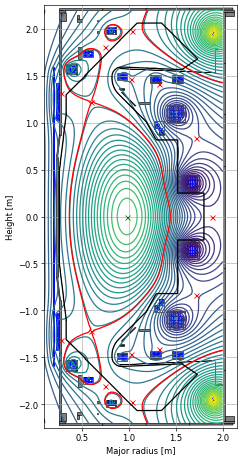

In [2]:
import os
import matplotlib.pyplot as plt
import freegs4e
import numpy as np

# build machine
from freegsnke import build_machine
tokamak = build_machine.tokamak(
    active_coils_path=f"../machine_configs/MAST-U/MAST-U_like_active_coils.pickle",
    passive_coils_path=f"../machine_configs/MAST-U/MAST-U_like_passive_coils.pickle",
    limiter_path=f"../machine_configs/MAST-U/MAST-U_like_limiter.pickle",
    wall_path=f"../machine_configs/MAST-U/MAST-U_like_wall.pickle",
)

# initialise equilibrium object
from freegsnke import equilibrium_update
eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,   # radial range
    Zmin=-2.2, Zmax=2.2,  # vertical range
    nx=65,                # number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,               # number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)  

# initialise profile object
from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(
    eq=eq,
    paxis=8.1e3,
    Ip=6.2e5,
    fvac=0.5,
    alpha_m=1.8,
    alpha_n=1.2
)

# initialise solver
from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)    

# set coil currents (these were found using the virtual circuits example)
current_values = {'Solenoid': 5000.0,
 'PX': 4664.8264042905585,
 'D1': 4817.449859117131,
 'D2': 1234.1293690145924,
 'D3': 1369.133338804566,
 'Dp': -905.4445404924389,
 'D5': 3757.2659244120455,
 'D6': -675.5868544077532,
 'D7': -94.84095712236905,
 'P4': -3536.0809826602153,
 'P5': -4568.000388616427,
 'P6': 0.0005793038603228533,
}

for key in current_values.keys():
    eq.tokamak[key].current = current_values[key]

# carry out forward solve
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

# plot the resulting equilbrium
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=60)
ax1.grid(True, which='both')
eq.plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()

Solving the linearised system requires inititialising the `nl_solver` object. This requires the:
- equilibrium and profiles. 
- plasma resistivity (for the lumped plasma resistance calculation).
- some options regarding mode cut-off frequencies, minimum Jacobian column norms, etc (we will revist these later in the notebook).

Within this object, the Jacobians are calculated and the matrices are built. Depending on the number of active coils and passive structures present in the system, this can take a while (as a GS solve is required for each). Following this, the matrices of the linearised system can be calculated and the eigenvalues/vectors found.

Here we will be using **all** available metal modes, however, later on we will show how to exclude those (via additional options to `nl_solver`) with specific frequencies, timescales, coupling, etc to reduce computational runtime (without losing too much information).

In [3]:
from freegsnke import nonlinear_solve

nonlinear_solver = nonlinear_solve.nl_solver(
    eq=eq, 
    profiles=profiles, 
    plasma_resistivity=1e-6, # this defines the lumped plasma resistances alternatively you can calculate the growth rates without the plasma model)
    min_dIy_dI=1e-10,        # this has been set artificially low in this example
    max_mode_frequency=1e10  # this has been set artificially high in this example
)

-----
Checking that the provided 'eq' and 'profiles' are a GS solution...
Forward static solve SUCCESS. Tolerance 4.78e-10 (vs. requested 1.00e-08) reached in 0/100 iterations.
-----
Instantiating nonlinear solver objects...
done.
-----
Identifying mode selection criteria...
      'threshold_dIy_dI', 'min_dIy_dI', and 'max_mode_frequency' option selected --> passive structure modes are selected according to these thresholds.
-----
Initial mode selection:
   Active coils
      total selected = 12 (out of 12)
   Passive structures
      138 selected with characteristic timescales larger than 'max_mode_frequency'
      0 selected that couple with the plasma more than 'threshold_dIy_dI', despite having fast timescales
      0 selected that couple with the plasma less than 'min_dIy_dI', despite having slow timescales
      total selected = 138 (out of 138)
   Total number of modes = 150 (12 active coils + 138 passive structures)
      (Note: some additional modes may be removed after Jacobi

From the printout we can see the steps being taken.

Important to look out for are the 'Initial mode selection' and 'Further mode reduction' sections that tell you which modes have been included in the analysis. Note again that the "final" mode (after including the actives and passives) comes from the plasma current equation. The number of modes can be adjusted with different options that we will see later. 

The 'Stability parameters' section shows a number of different metrics used to gauge plasma vertical instability. In 'Deformable plasma metrics' we have the growth rate of the unstable mode and the associated timescale (i.e. 1/(growth_rate)). In the 'Rigid plasma metrics' section, we return a number of commonly used parameters that do not make use of the Jacobian matrix (we will discuss these later too). 

### Extracting data and visualising

Next, we will show to access some of the calculated data and how to visualise a few things. 

In [4]:
# accessing the number of modes
print(f"Total number of modes excl. plasma current = {nonlinear_solver.n_metal_modes}")   # total (actives + passives)
print(f"Total number of active coils = {nonlinear_solver.n_active_coils}")   # actives
print(f"Total number of passive structures = {nonlinear_solver.n_passive_coils}")   # passives

Total number of modes excl. plasma current = 150
Total number of active coils = 12
Total number of passive structures = 138


In [6]:
# accessing the growth rates (via the timescales)
timescales = nonlinear_solver.linearised_sol.all_timescales # all eigenvalues: timescales (descending order)
growth_rates = 1/timescales                                 # growth rates are simply 1/timescales (descending order)
modes = nonlinear_solver.linearised_sol.all_modes           # all eigenvectors (columns in same order as e'values)

In [13]:
# extracting the unstable mode(s) - typically only one
mask = (timescales > 0)
idx = np.where(mask)[0][0] # index of unstable mode
unstable_timescales = timescales[mask]
unstable_modes = np.squeeze(modes[:,mask])

We can visualise the poloidal flux produced by the unstable mode using the following code. We can also do this for other (stable) modes if required.

Mode 19 ---> unstable
Growth rate = 2.78e+02 [1/s]
Timescale = 3.60e-03 [s]


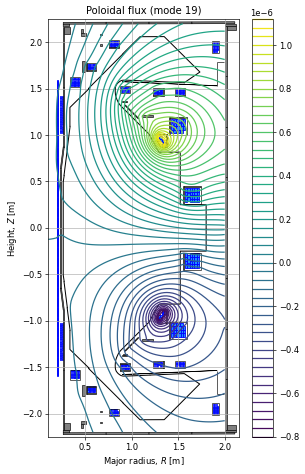

In [16]:
# mode number (choose which one you want to visualise)
i = idx # default is unstable mode
mode_currents = np.real(modes[:,i])

# the associated instability timescale and growth rate
print(f"Mode {i} ---> {'stable' if np.real(timescales[i]) < 0 else 'unstable'}")
print(f"Growth rate = {np.real(growth_rates[i]):.2e} [1/s]")
print(f"Timescale = {np.real(timescales[i]):.2e} [s]")

# multiply each metal current (from the eigenvector) with its corresponding Greens matrix and sum
# (don't forget to omit the plasma current mode, i.e. the final element)
flux = np.sum(mode_currents[0:-1, np.newaxis, np.newaxis] * nonlinear_solver.vessel_modes_greens, axis=0)

# plot
fig, ax = plt.subplots(1, 1, figsize=(5, 8), dpi=60)
ax.grid(True, which='both')
ax.set_aspect('equal')
ax.set_xlim(0.1, 2.15)
ax.set_ylim(-2.25, 2.25)
ax.set_title(f"Poloidal flux (mode {i})")
ax.set_xlabel(r'Major radius, $R$ [m]')
ax.set_ylabel(r'Height, $Z$ [m]')
plt.tight_layout()

eq.tokamak.plot(axis=ax,show=False)
ax.plot(eq.tokamak.wall.R, eq.tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im = ax.contour(eq.R, eq.Z, flux, levels=50)                        
cbar = plt.colorbar(im, ax=ax, fraction=0.09)

Next, we can extract two different plasma current density $J_{p}(\psi, R,Z)$ maps: call them $J_{p}^{deform}$ and $J_{p}^{rigid}$.

The first corresponds to an application of the unstable mode currents to the equilbirium, solving the GS equation, and observing the "deformable" movement of the plasma core (it shifts in $(R,Z)$ and also it's boundary will displace). This results in a new current density map $J_{p}^{deform}$. 

The second corresponds to taking the $(R,Z)$ shifts in the current centres (from $J_{p}^{deform}$) and shifting the $J_p$ map from the orginal equilibrium. In this case we observe a "rigid" displacement of the plasma current density: $J_{p}^{rigid}$. 

While they do not look significantly different in the case presented here, they will when studying more vertically unstable plasmas.


Rate of change of Rcurrent wrt unstable mode = 6.48e-07 [m].
Rate of change of Zcurrent wrt unstable mode = -1.30e-05 [m].


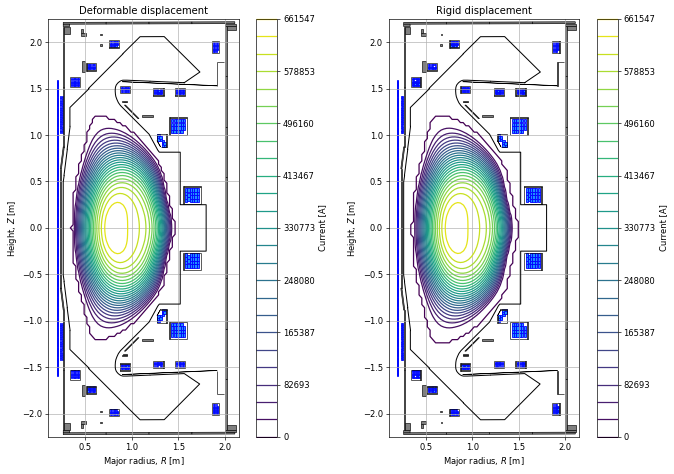

In [20]:
# data
jtor_maps = nonlinear_solver.deformable_vs_rigid_jtor  

# rate of change of R and Z current centre of plasma wrt to the unstable mode only
dRZd_unstable_mode = nonlinear_solver.dRZd_unstable_mode
print(f"Rate of change of Rcurrent wrt unstable mode = {dRZd_unstable_mode[0]:.2e} [m].")
print(f"Rate of change of Zcurrent wrt unstable mode = {dRZd_unstable_mode[1]:.2e} [m].")

# plot

min_lev = min(np.min(jtor_maps[0]),np.min(jtor_maps[1]))
max_lev = max(np.max(jtor_maps[0]),np.max(jtor_maps[1]))
levels = np.linspace(min_lev, max_lev, 25)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), dpi=60)

ax1.grid(True, which='both')
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_title(f"Deformable displacement")
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')
plt.tight_layout()

eq.tokamak.plot(axis=ax1,show=False)
ax1.plot(eq.tokamak.wall.R, eq.tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im1 = ax1.contour(eq.R, eq.Z, jtor_maps[0], levels=levels)                        
cbar = plt.colorbar(im1, ax=ax1, fraction=0.09)
cbar.set_label('Current [A]')


ax2.grid(True, which='both')
ax2.set_aspect('equal')
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)
ax2.set_title(f"Rigid displacement")
ax2.set_xlabel(r'Major radius, $R$ [m]')
ax2.set_ylabel(r'Height, $Z$ [m]')

eq.tokamak.plot(axis=ax2,show=False)
ax2.plot(eq.tokamak.wall.R, eq.tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im2 = ax2.contour(eq.R, eq.Z, jtor_maps[1], levels=levels)                        
cbar = plt.colorbar(im2, ax=ax2, fraction=0.09)
cbar.set_label('Current [A]')


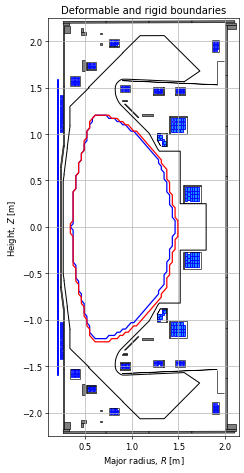

In [33]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8), dpi=60)

ax1.grid(True, which='both')
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_title(f"Deformable and rigid boundaries")
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')
plt.tight_layout()

eq.tokamak.plot(axis=ax1,show=False)
ax1.plot(eq.tokamak.wall.R, eq.tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
ax1.contour(eq.R, eq.Z, jtor_maps[0], levels=[0], colors='b')        
ax1.contour(eq.R, eq.Z, jtor_maps[1], levels=[0], colors='r')  


In the next plot, we show how to visualise the derivative of the plasma current density with respect to the metal currents (i.e. visualise the finite difference calculated Jacobian).

As before, just choose a mode number and plot.

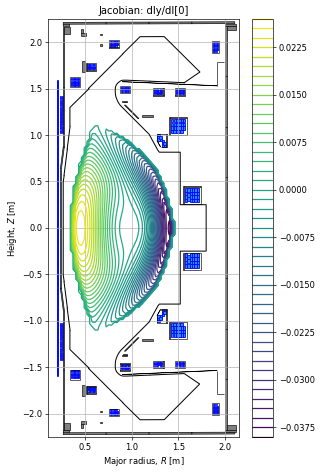

In [83]:
# extract the Jacobian (no. plasma current points x no. modes) 
# i.e. the full finite-difference Jacobian of plasma current density points wrt metal currents 
dIydI = nonlinear_solver.dIydI       

# choose the mode number you want to plot
i = 0

# extracts the column of the Jacobian and places into the correct grid for plotting
derivs = np.full(nonlinear_solver.limiter_handler.mask_inside_limiter.shape, np.nan)
derivs[nonlinear_solver.limiter_handler.mask_inside_limiter] = dIydI[:,i]

# plot
fig, ax = plt.subplots(1, 1, figsize=(5, 8), dpi=60)
ax.grid(True, which='both')
ax.set_aspect('equal')
ax.set_xlim(0.1, 2.15)
ax.set_ylim(-2.25, 2.25)
ax.set_title(f"Jacobian: dIy/dI[{i}]")
ax.set_xlabel(r'Major radius, $R$ [m]')
ax.set_ylabel(r'Height, $Z$ [m]')
plt.tight_layout()

eq.tokamak.plot(axis=ax,show=False)
ax.plot(eq.tokamak.wall.R, eq.tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im = ax.contour(eq.R, eq.Z, derivs, levels=50)                        
cbar = plt.colorbar(im, ax=ax, fraction=0.09)


### Stability parameters

We now return to the 'Stability parameters' that were returned when we instantiated the `nl_solver` object. In addition to the deformable growth rate, we can extract other commonly used stability metrics (that assume a rigid, non-deformable plasma).

#### Leuer parameter

The first is the stability parameter outlined in equation (6) of [Leuer (1989)](https://www.tandfonline.com/doi/abs/10.13182/FST89-A39747). See the reference for more details on its interpretation.

The (generalised) Leuer stability parameter is defined as the ratio of stabilising force gradient to de-stabilising force gradient acting on the system:

\begin{equation}
    f := \frac{f_{stab}}{f_{destab}} = \frac{\bold{I}_y^T M'_{y,m} M^{-1}_{m,m} M'_{m,y} \bold{I}_y}{\bold{I}_y^T M''_{y,m} \bold{I}_m},
\end{equation}

where $M'$ denotes the derivative (and second derivative $M''$) of the mutual inductances with respect to the $Z$ coordinate. Other matrices are as they are defined above. We can find these derivatives using the relations:

\begin{align}
    \frac{d}{dZ} M_{y,m} = \frac{d}{dZ} M (R_y, Z_y ; R_m, Z_m) &= \frac{d}{dZ} 2 \pi G (R_y, Z_y ; R_m, Z_m) \\
    &= \frac{d}{dZ} 2 \pi \psi (R_y, Z_y ; R_m, Z_m) \\
    &= - 2 \pi R_m B_R (R_y, Z_y ; R_m, Z_m). 
\end{align}

Here, $G$ is the Greens function between the plasma locations and the metal locations (which is equal to the poloidal flux $\psi_{y,m}$ at the metal locations produced by a unit current at the plasma locations). We can then use the relation $B_R = - (d \psi / dZ) / R$, where $B_R$ is the radial magnetic field. Note the actual calculation of this is slightly more involed when the metals are defined using filaments (see source code in nonlinear_solve.py).

The second derivative is the same except we need $d B_R/ dZ$ instead of $B_R$. 

This stability parameter can be calculated in different ways by choosing which metals ($m$) to include in the calculation. Note, however, that no mode decomposition (see below) is performed when calculating these metrics. 

Note, however, in this particular equilibrium the metrics look very similar because there are no currents in the passive structures!

In [38]:
print(f"Stabilisation force gradient (from all metals) = {nonlinear_solver.all_coils_stab_force}")
print(f"Stabilisation force gradient (from active coils) = {nonlinear_solver.actives_stab_force}")
print(f"Stabilisation force gradient (from passive coils) = {nonlinear_solver.passives_stab_force}")
print("---")
print(f"De-stabilisation force gradient (from all metals) = {nonlinear_solver.all_coils_destab_force}")
print(f"De-tabilisation force gradient (from active coils) = {nonlinear_solver.actives_destab_force}")
print(f"De-tabilisation force gradient (from passive coils) = {nonlinear_solver.passives_destab_force}")
print("---")
print(f"Leuer parameter (passives over actives) = {nonlinear_solver.passives_stab_force/nonlinear_solver.actives_destab_force}")
print(f"Leuer parameter (all metals over actives) = {nonlinear_solver.all_coils_stab_force/nonlinear_solver.actives_destab_force}")
print(f"Leuer parameter (all metals over all metals) = {nonlinear_solver.all_coils_stab_force/nonlinear_solver.all_coils_destab_force}")

Stabilisation force gradient (from all metals) = 153218.5208463839
Stabilisation force gradient (from active coils) = 88017.72509664345
Stabilisation force gradient (from passive coils) = 153217.1961554046
---
De-stabilisation force gradient (from all metals) = 104708.18928764414
De-tabilisation force gradient (from active coils) = 104708.18928764414
De-tabilisation force gradient (from passive coils) = 0.0
---
Leuer parameter (passives over actives) = 1.4632780606538927
Leuer parameter (all metals over actives) = 1.4632907119182141
Leuer parameter (all metals over all metals) = 1.4632907119182141


#### Portone parameter (need to check/fix)


The second is the stability parameter defined by [Portone (2005)](https://iopscience.iop.org/article/10.1088/0029-5515/45/8/021).

#### what is it, what it measn, how its defined?

The (inductive) stability margins are found by solving for the eigenvalues of:

$$ A := - M_{m,m}^{-1} M_{m,y} \frac{\partial \bold{I}_y}{\partial \bold{I}_m} \Bigg|_{GS} - \bold{I}, $$

where $\bold{I}$ is the identity matrix. We say "inductive" because no resistance terms are present in this metric.

The positive eigenvalue corresponds to the unstable inductive stability margin. 

It measures what?

In [74]:
# section on the stability margin
# nonlinear_solver.linearised_sol.all_stability_margins # all calculated stability margins 

In [ ]:
# extract the L and S matrices
n = nonlinear_solver.linearised_sol.n_independent_vars
L = nonlinear_solver.linearised_sol.M0matrix[0:n, 0:n]
S = -nonlinear_solver.linearised_sol.dMmatrix[0:n, 0:n]

# find e'values
A = np.linalg.solve(L, S) - np.eye(n)
np.sort(np.linalg.eigvals(A),)



# extract the L and S matrices
n = nonlinear_solver.linearised_sol.n_independent_vars
L = nonlinear_solver.linearised_sol.M0matrix[0:n, 0:n]
Ls = nonlinear_solver.linearised_sol.dMmatrix[0:n, 0:n]

LL = L + Ls

# find e'values
A = -np.linalg.inv(L)*LL
np.sort(np.linalg.eigvals(A))


# # extract stability margin
# mask = self.all_stability_margins > 0
# self.stability_margin = self.all_stability_margins[
#     mask
# ]  # the positive (i.e. unstable) eigenvalues

### Removing the plasma equation

The growth rates can also be computed in the case where we assume $\bold{\dot{I}}_p = 0$. For this, the final row/column of the matrices are omitted.

This may be useful, for example, if you do not have a good intuition for what the `plasma_resistivity` parameter (in the `nl_solver` object) is. Recall that this goes into the "lumped" plasma equation and therefore the state space matrices when calculating the growth rates. 

To extract these timescales and modes, simply call the following:

In [34]:
# accessing the growth rates (via the timescales)
timescales_const_Ip = nonlinear_solver.linearised_sol.all_timescales_const_Ip # all eigenvalues: timescales (descending order) without plasma equation
growth_rates_const_Ip = 1/timescales_const_Ip                                 # all eigenvalues: growth rates (descending order) without plasma equation
modes_const_Ip = nonlinear_solver.linearised_sol.all_modes_const_Ip           # all eigenvectors (columns in same order as e'values) without plasma equation

### Mode decomposition

The initial calculation of the growth rates was quite length because we included all of the passive structures (each of which then require a GS solve to calculate the Jacobian matrix). 

We can in fact carry out mode decomposiiton, i.e. exclude a number of (passive structure) modes that couple weakly to the plasma, and save some compute time. Once a subset of the original passive structures modes has been selected, FreeGSNKE performs mode decomposition and solves for the eigenvalues/vectors as outlined in the [Appendix 2 of Amorisco et al. (2024)](https://pubs.aip.org/aip/pop/article/31/4/042517/3286904/FreeGSNKE-A-Python-based-dynamic-free-boundary).

There are, however, a number of different ways to choose this subset of passive structure modes. Once one is chosen, the same analysis above can be carried out as before using the eigenvalues/modes.

#### Option 1: Fixing the number of passive structure modes explicity

While the active coils will always be included as modes, you can set the number of passive structure modes directly via the `fix_n_vessel_modes` option (choose a number between 0 and the number of passive structures in the tokamak object). 

The order in which the passive modes are chosen is such that:
- A first estimate of $\|  \frac{\partial \bold{I}_y}{\partial \bold{I}_m} \|$ is calculated (before the full Jacobian calculation) for all possible modes (actives + passive strucutres) without fully solving the GS equation for each. This is done by perturbing the currents in the modes (active and passive coils), updating the poloidal flux produced by these currents, and then evaluating the plasma current density $J_p(R,Z, \psi$)$. Here, $\psi$ is the total poloidal flux, i.e. the plasma and the metals contributions combined. 
- Each passive mode is then ordered by the size of its $\|  \frac{\partial \bold{I}_y}{\partial \bold{I}_m} \|$, from highest (strongest coupling) to lowest (weakest coupling). 
- We then choose the top (strongest coupled) `fix_n_vessel_modes` to include in our decomposition. 

As a rough rule of thumb, the more modes that are added, the larger the timescale of the unstable mode is expected to be (i.e. a smaller growth rate). Though this rule is not thought to be strict.

In [35]:
# instantiate the nl_solver object with fixed mode
nonlinear_solver_fixed_modes = nonlinear_solve.nl_solver(
    eq=eq, 
    profiles=profiles, 
    plasma_resistivity=1e-6,
    fix_n_vessel_modes=50,
)

-----
Checking that the provided 'eq' and 'profiles' are a GS solution...
Forward static solve SUCCESS. Tolerance 4.78e-10 (vs. requested 1.00e-08) reached in 0/100 iterations.
-----
Instantiating nonlinear solver objects...
done.
-----
Identifying mode selection criteria...
      'fix_n_vessel_modes' option selected --> passive structure modes that couple most to the strongest passive structure mode are being selected.
-----
Initial mode selection:
   Active coils
      total selected = 12 (out of 12)
   Passive structures
      50 selected using 'fix_n_vessel_modes'
   Total number of modes = 62 (12 active coils + 50 passive structures)
      (Note: some additional modes may be removed after Jacobian calculation)
-----
Building the 3051 x 63 Jacobian (dIy/dI) of plasma current density (inside the LCFS) with respect to all metal currents and the total plasma current.
done.
-----
Stability paramters:
   Deformable plasma metrics:
      Growth rate = [ 371.36571678+0.j 9671.83760198+0.j

Note that in this case we have two unstable modes.

We can plot how these look using similar code as before, except we need to remember that now we've done a mode decomposition, the eigenmodes need to be transformed back into the original metal currents. This is done in the plotting cell below. 

In [57]:
# accessing the growth rates (via the timescales)
timescales = nonlinear_solver_fixed_modes.linearised_sol.all_timescales # all eigenvalues: timescales (descending order)
growth_rates = 1/timescales                                             # growth rates are simply 1/timescales (descending order)
modes = nonlinear_solver_fixed_modes.linearised_sol.all_modes           # all eigenvectors (columns in same order as e'values)

In [58]:
# extracting the unstable mode(s)
mask = (timescales > 0)
idx = np.where(mask)[0] # index of unstable mode(s)
unstable_timescales = timescales[mask]
unstable_modes = np.squeeze(modes[:,mask])

Mode 22 ---> unstable
Growth rate = 3.71e+02 [1/s]
Timescale = 2.69e-03 [s]


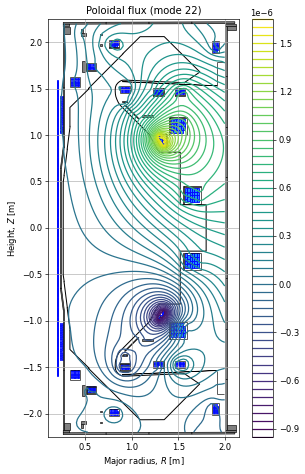

In [78]:
# mode number (choose which one you want to visualise)
i = idx[0]   # unstable modes
# i = 0 to 62 (all modes)

# this function transforms the (decomposed) mode currents back to regular metal currents
# (don't forget to omit the plasma current mode, i.e. the final element)
mode_currents = nonlinear_solver_fixed_modes.evol_metal_curr.IdtoIvessel(np.real(modes[0:-1,i]))

# the associated instability timescale and growth rate
print(f"Mode {i} ---> {'stable' if np.real(timescales[i]) < 0 else 'unstable'}")
print(f"Growth rate = {np.real(growth_rates[i]):.2e} [1/s]")
print(f"Timescale = {np.real(timescales[i]):.2e} [s]")

# multiply each metal current (from the eigenvector) with its corresponding Greens matrix and sum
flux = np.sum(mode_currents[:, np.newaxis, np.newaxis] * nonlinear_solver_fixed_modes.vessel_modes_greens, axis=0)

# plot
fig, ax = plt.subplots(1, 1, figsize=(5, 8), dpi=60)
ax.grid(True, which='both')
ax.set_aspect('equal')
ax.set_xlim(0.1, 2.15)
ax.set_ylim(-2.25, 2.25)
ax.set_title(f"Poloidal flux (mode {i})")
ax.set_xlabel(r'Major radius, $R$ [m]')
ax.set_ylabel(r'Height, $Z$ [m]')
plt.tight_layout()

eq.tokamak.plot(axis=ax,show=False)
ax.plot(eq.tokamak.wall.R, eq.tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im = ax.contour(eq.R, eq.Z, flux, levels=50)                        
cbar = plt.colorbar(im, ax=ax, fraction=0.09)

Note that if a mode decomposition is carried out, then the eigenmodes that come out won't correspond to the coils order or the original machine and so they need to be converted back. 
This can be done with 

mode = 
nonlinear_solver_fixed_modes.evol_metal_curr.IdtoIvessel(Id=)


Analysis for me: looking into evolution of largest timescale over time (and why there might be two timescales). 

In [107]:
# run for lots of different values (takes a long time!)

n_vessel_modes = [0, 20, 40, 60, 80, 100, 120, 138]

timescales = []

for value in n_vessel_modes:

    nonlinear_solver_fixed_modes = nonlinear_solve.nl_solver(
        eq=eq, 
        profiles=profiles, 
        plasma_resistivity=1e-6, # this needs to be set (alternatively you can calculate the growth rates without the plasma model)
        min_dIy_dI=1e-10,        # this has been set artificially low in this example 
        max_mode_frequency=1e10, # this has been set artificially high in this example
        fix_n_vessel_modes=value,
    )

    timescales.append(nonlinear_solver_fixed_modes.linearised_sol.all_timescales)


-----
Checking that the provided 'eq' and 'profiles' are a GS solution...
Forward static solve SUCCESS. Tolerance 8.29e-10 (vs. requested 1.00e-08) reached in 0/100 iterations.
-----
Instantiating nonlinear solver objects...
done.
-----
Identifying mode selection criteria...
      'fix_n_vessel_modes' option selected --> passive structure modes that couple most to the strongest passive structure mode are being selected.
-----
Initial mode selection:
   Active coils
      total selected = 12 (out of 12)
   Passive structures
      0 selected using 'fix_n_vessel_modes'
   Total number of modes = 12 (12 active coils + 0 passive structures)
      (Note: some additional modes may be removed after Jacobian calculation)
-----
Building the 3051 x 13 Jacobian (dIy/dI) of plasma current density (inside the LCFS) with respect to all metal currents and the total plasma current.
done.
-----
      No unstable modes found: either plasma stable, or more likely, it is Alfven unstable (i.e. needs more s

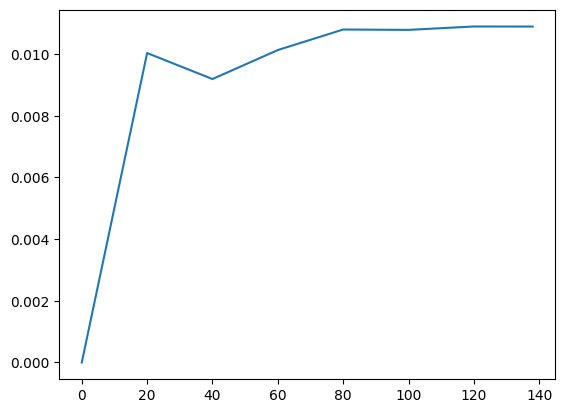

In [108]:
unstable_timescales = np.zeros(len(timescales))
for i, arr in enumerate(timescales):
    try:
        unstable_timescales[i] = max(np.real(arr[np.real(arr) > 0]))
    except:
        pass

plt.plot(n_vessel_modes, unstable_timescales)

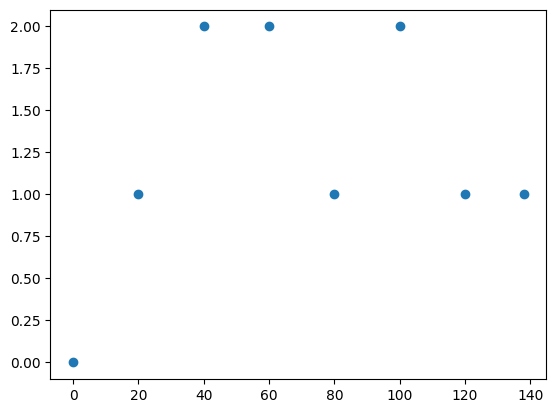

In [116]:
num_unstable_modes = np.zeros(len(timescales))
for i, arr in enumerate(timescales):
    try:
        num_unstable_modes[i] = len(arr[np.real(arr) > 0])
    except:
        pass

plt.scatter(n_vessel_modes, num_unstable_modes)

### Other options in `nl_solver`

There are other ...

### More advanced study: moving coils/passives

In [ ]:
Could do this with one of the toy tokamak models from Nico's analysis. (see what else he had in there)

